# RUL Transformer
This notebook creates a Transformer model for RUL prediction of the CMAPSS dataset.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import DataUtils
import Masking

C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 64
trainloader, testloader = DataUtils.get_dataloaders(batch_size, 1)

In [4]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
columns_kept = [False, False, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, False]
print(columns_kept)

[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]


In [5]:
example = next(enumerate(trainloader))
ex_X = example[1][0]
print(ex_X.shape)

ex_y = example[1][1]
print(ex_y.shape)

torch.Size([64, 542, 27])
torch.Size([64])


In [6]:
class RULTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prediction_window = 1
        self.input_len = 542
        self.n_cols = 24
        self.embed_dim = 128
        
        self.input_projection = nn.Linear(self.input_len*self.n_cols, self.embed_dim)
        self.positional_embed = nn.Parameter(torch.randn(self.embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=4, activation="gelu", dropout=0.1)
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        self.rul_head = nn.Sequential(nn.Linear(self.embed_dim, 2048),
                                           nn.ReLU(),
                                           nn.Linear(2048, self.prediction_window))
    
    def forward(self, x):
        pad_amount = self.input_len - x.size(1)
        x = torch.nn.functional.pad(x, (0, 0, 0, pad_amount))
        
        x = x.flatten(1)
        z = self.input_projection(x)
        z = z + self.positional_embed
        z = self.transformer_blocks(z)
        z = self.rul_head(z)
        
        return z.squeeze(1)

In [7]:
rul_tran = RULTransformer()

In [8]:
rul_tran(ex_X[:,:,columns_kept].float())

tensor([-0.6460, -0.5869, -0.6424, -0.5692, -0.6004, -0.6169, -0.6066, -0.5629,
        -0.5667, -0.6243, -0.5130, -0.6375, -0.5535, -0.6258, -0.6021, -0.6154,
        -0.5222, -0.6014, -0.6027, -0.5648, -0.6460, -0.5912, -0.6298, -0.6571,
        -0.5755, -0.5533, -0.6148, -0.5584, -0.6353, -0.6283, -0.6043, -0.5929,
        -0.5497, -0.6203, -0.5633, -0.6459, -0.6163, -0.6149, -0.6006, -0.5829,
        -0.6010, -0.5489, -0.5938, -0.5544, -0.6009, -0.6051, -0.5774, -0.6092,
        -0.6114, -0.5560, -0.5781, -0.6040, -0.6217, -0.6319, -0.5807, -0.6616,
        -0.5774, -0.6281, -0.6070, -0.6213, -0.6485, -0.5623, -0.6175, -0.5442],
       grad_fn=<SqueezeBackward1>)

In [9]:
objective = nn.MSELoss()

rul_tran = RULTransformer()

lr = 1e-4
n_epochs = 1000
optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        yhat = rul_tran(X[:,:,columns_kept].float())
        loss = objective(yhat, y.float())
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:34<00:00,  2.09it/s]


Epoch: 1 Loss: 14516.2216796875


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:27<00:00,  2.19it/s]


Epoch: 2 Loss: 1533.91357421875


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:34<00:00,  2.09it/s]


Epoch: 3 Loss: 704.1243896484375


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:23<00:00,  2.24it/s]


Epoch: 4 Loss: 376.5543212890625


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 5 Loss: 148.78121948242188


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 6 Loss: 238.72821044921875


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:27<00:00,  2.20it/s]


Epoch: 7 Loss: 206.32623291015625


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 8 Loss: 436.2146911621094


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 9 Loss: 133.2357635498047


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 10 Loss: 64.08036041259766


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.23it/s]


Epoch: 11 Loss: 155.73114013671875


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.23it/s]


Epoch: 12 Loss: 285.14996337890625


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:26<00:00,  2.21it/s]


Epoch: 13 Loss: 148.39962768554688


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 14 Loss: 38.32655715942383


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 15 Loss: 153.46131896972656


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 16 Loss: 157.12286376953125


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 17 Loss: 55.57726287841797


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 18 Loss: 40.98443603515625


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 19 Loss: 164.82887268066406


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 20 Loss: 379.2289123535156


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 21 Loss: 56.620880126953125


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.23it/s]


Epoch: 22 Loss: 39.15332794189453


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.23it/s]


Epoch: 23 Loss: 30.58281707763672


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch: 24 Loss: 29.981536865234375


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 25 Loss: 75.77269744873047


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch: 26 Loss: 160.7204132080078


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:30<00:00,  2.14it/s]


Epoch: 27 Loss: 74.7339859008789


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [02:30<00:00,  2.15it/s]


Epoch: 28 Loss: 105.62945556640625


  4%|███▌                                                                             | 14/323 [00:07<02:39,  1.94it/s]


KeyboardInterrupt: 

In [15]:
test_mses = []
yhats = []
ys = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
            yhat = rul_tran(X[:,:,columns_kept].float())
            yhats.append(yhat.values)
            ys.append(y)
            test_mse = objective(yhat, y.float())
            test_mses.append(test_mse.item())
print("Test MSE:", np.mean(test_mses))

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:50<00:00,  4.04it/s]

Test MSE: 3225.7484491953037


In [23]:
yhats[0]

tensor([210.9679, 194.1083, 217.5564, 207.1253, 204.0876, 225.3761, 238.6421,
        211.9415, 232.4276, 216.7056, 214.0647, 203.5335, 197.0618, 201.2545,
        196.0110, 197.8357, 179.1796, 179.7321, 195.9025, 183.6204, 183.0923,
        178.7597, 170.3666, 177.8416, 167.1471, 168.2934, 168.8532, 176.5083,
        157.2803, 155.9755, 152.4332, 225.9115, 208.0154, 202.5079, 189.9653,
        190.8138, 195.0503, 181.0711, 167.8269, 168.5141, 163.0723, 171.4613,
        177.1479, 172.3226, 181.6575, 173.2844, 182.9755, 172.3159, 179.1907,
        187.5553, 179.6185, 179.1948, 183.3639, 176.9701, 170.3868, 173.9801,
        159.2134, 158.2923, 158.6102, 157.9540, 169.1164, 167.9136, 170.6057,
        164.4907])

C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: only one element tensors can be converted to Python scalars

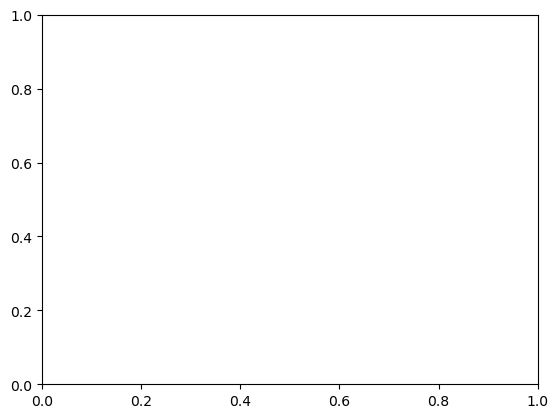

In [16]:
plt.plot(yhats)
pl.plot(ys)

In [13]:
np.sqrt(3226)

56.79788728465171

### Saving the Model

In [10]:
torch.save(rul_tran.state_dict(), './saved_models/rul_transformer_prototype_nomask.pt')